<a href="https://colab.research.google.com/github/bielalpha/Tensorflow_study/blob/master/right_Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo usando treinamento por transferencia

In [ ]:
!nvidia-smi

Wed Oct 12 19:38:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import itertools

In [ ]:
#Aqui criamos a function que vai realizar a visualizacao da matriz de confusao de maneira mais elegante
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    #tamanho da figura
    plt.figure(figsize=(10,10))
    #
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #titulo do plot
    plt.title(title)
    #cor da dos quadrados
    plt.colorbar()
    #quantidade de pontos do grafico
    tick_marks = np.arange(len(classes))
    #pontos da linha x
    plt.xticks(tick_marks, classes, rotation=45)
    #pontos da linha y
    plt.yticks(tick_marks, classes)
    #aplica normalizacao dos dados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Quantidade de imagens usadas numa epoca
BATCH_SIZE = 32
#tamanho da imagem que vai da entrada no modelo para treino
IMG_SIZE = (160, 160)
#lib que busca o caminho do conjunto de dados
train_test_dir = os.path.join('/content/drive/MyDrive/', 'Disiase - Copy')
#usando um utilitario do keras para carregar as imagens em memoria 
#parametro shuffle como True para que os dados sejam randomicos caso contrario iria retornar um array com um unico dado EX: [1,1,1,1,1,1,1,1,1]
train_dataset = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7797 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7797 files belonging to 3 classes.


In [ ]:
new_directory = os.path.join('/content/drive/MyDrive/', 'Disiase_refactor')
validation_dataset_true = tf.keras.utils.image_dataset_from_directory(new_directory,
                                                                 shuffle=False,
                                                                 seed=123,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 32 files belonging to 3 classes.


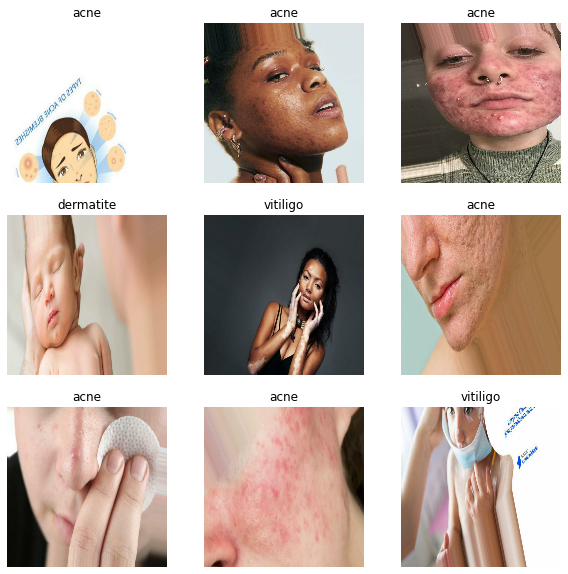

In [ ]:
#retirando os rotulos de cada imagem
class_names = train_dataset.class_names
#printando imagens para saber o que esta sendo carregado do dataset de treino
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#como nao existe dados de teste e validacao vamos criar os mesmo
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
#aqui printamos a quantidade de dados que vao ser usados para teste e validacao
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 196
Number of test batches: 48


In [ ]:
#Aqui vamos salvar nossos dados para desempenho
#com ajuda das threads vamos poder ao mesmo tempo que consumimos os dados para treino vamos ler 
#os proximos dados e assim que eles forem solicitados vamos poder usalos de imediato sem que seja 
#necessario esperar pela leitura pois a thread atual ja nos forneceu esse dado ja lida e processado
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Com o tf.keras.Sequential a gente pode criar novas posicoes de imagem afim de garantir que o nosso modelo consiga prever 
#varias pespectivas dessa imagem evitando o overfiting que seria o caso do modelo se ajustar demais e nao conseguir generalizar as novas imagens
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

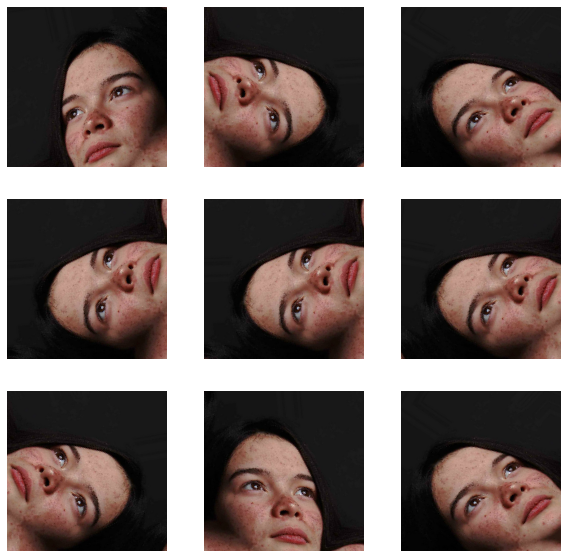

In [ ]:
#mais uma visualizacao do que o modelo vai receber de parametro de entrada
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#aqui criamos o pre-processador de imagens, onde vai ser adequado o formato da imagem para que o modelo entenda essa imagem
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
#Aqui vamos uniformizar as imagens para que todas fiquem numa mesma escala
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
#Criamos o modelo
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#criamos um interador para saber a quantidade de imagens que o modelo vai usar na hora de executar cada epoca
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#congelamos a camada convolucional afim de previnir que o peso das camadas treinas a priori no modelo afetem nosso treinamento inicial
base_model.trainable = False

In [ ]:
# Aqui podemos ver a arquitetura do modelo
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
#Aqui vamos colocar uma camada que vai transformar os dados para um dimensao e como consequencia tendo um unico array com todos o valores que compoe cada uma das 32 imagens
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Aqui vamos obter o valor bruto de cada previsao zero ou um
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#aqui jutamos tudo que fizemos na linha anteriores para formar o medelo propriamente
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#o dropout vai definir a entrada aleatoriamente para zero afim de evitar o overfitting
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# no base learning definimos o grau de aprendizado para cada uma das epocas
base_learning_rate = 0.0001
#Usamos tambem o otimizador adam pois teoricamente eo melhor pois usa menos memoria e tras bons resultados
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#realizado um evaluate do modelo sem treinar para 
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

196/196 [==============================] - 539s 2s/step - loss: 0.2941 - accuracy: 0.2877


In [ ]:
#visualizando taxa de perda e acuracia
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.29
initial accuracy: 0.29


In [ ]:
#treinamento, iniciando em 10 epocas usando o conunto de traino e validacao
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
244/244 [==============================] - 60s 230ms/step - loss: -0.3480 - accuracy: 0.3337 - val_loss: -0.6363 - val_accuracy: 0.3396
Epoch 2/10
244/244 [==============================] - 60s 241ms/step - loss: -0.9842 - accuracy: 0.3417 - val_loss: -1.1956 - val_accuracy: 0.3421
Epoch 3/10
244/244 [==============================] - 57s 230ms/step - loss: -1.5892 - accuracy: 0.3444 - val_loss: -1.7468 - val_accuracy: 0.3445
Epoch 4/10
244/244 [==============================] - 58s 235ms/step - loss: -2.1472 - accuracy: 0.3471 - val_loss: -2.2863 - val_accuracy: 0.3485
Epoch 5/10
244/244 [==============================] - 56s 228ms/step - loss: -2.7381 - accuracy: 0.3487 - val_loss: -2.8318 - val_accuracy: 0.3517
Epoch 6/10
244/244 [==============================] - 58s 235ms/step - loss: -3.3318 - accuracy: 0.3478 - val_loss: -3.4021 - val_accuracy: 0.3506
Epoch 7/10
244/244 [==============================] - 57s 230ms/step - loss: -3.8793 - accuracy: 0.3497 - val_loss: -3

In [ ]:
#agora vamos treinar o modelo com a camada de convolucao ativada
base_model.trainable = True

In [ ]:
# Verificamos quantas camadas o modelo base tem
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# congelando todas a camadas antes do ajuste fino
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#vamos compilar o modelo onde mudamos a perda para BinaryCrossentropy que calcula a entropia entre rotulo verdadeiro e previstos, basicamente valida se o dados estao batendo ou nao, no caso usamos o from_logits=True para melhorar a precisao
#nesse caso o otimizador vai ser o RMSprop pois ele evita que o valores oscilem para baixo e como consequencia melhora os valores gerais do modelo
#metrica de avaliacao vai ser a acuracia mesmo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
#treinamento comeca onde o treinamento antes do ajuste fino acabou, entao adicionamos mais 10 epocas
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
244/244 [==============================] - 65s 241ms/step - loss: -64.8050 - accuracy: 0.3563 - val_loss: -102.6582 - val_accuracy: 0.3833
Epoch 11/20
244/244 [==============================] - 59s 237ms/step - loss: -118.0061 - accuracy: 0.3903 - val_loss: -128.7751 - val_accuracy: 0.4095
Epoch 12/20
244/244 [==============================] - 59s 240ms/step - loss: -133.8157 - accuracy: 0.4023 - val_loss: -133.5726 - val_accuracy: 0.4348
Epoch 13/20
244/244 [==============================] - 59s 237ms/step - loss: -145.0463 - accuracy: 0.4200 - val_loss: -145.1942 - val_accuracy: 0.4502
Epoch 14/20
244/244 [==============================] - 61s 246ms/step - loss: -155.0264 - accuracy: 0.4331 - val_loss: -159.0839 - val_accuracy: 0.4611
Epoch 15/20
244/244 [==============================] - 59s 238ms/step - loss: -163.2719 - accuracy: 0.4495 - val_loss: -169.9813 - val_accuracy: 0.4645
Epoch 16/20
244/244 [==============================] - 60s 242ms/step - loss: -170.7348 -

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

48/48 [==============================] - 7s 120ms/step - loss: -205.1534 - accuracy: 0.4824
Test accuracy : 0.482421875


Predictions:
 [1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1]
Labels:
 [2 1 2 2 1 0 0 2 0 2 2 1 1 1 0 0 1 2 1 0 1 0 2 0 0 0 1 1 0 1 1 2]


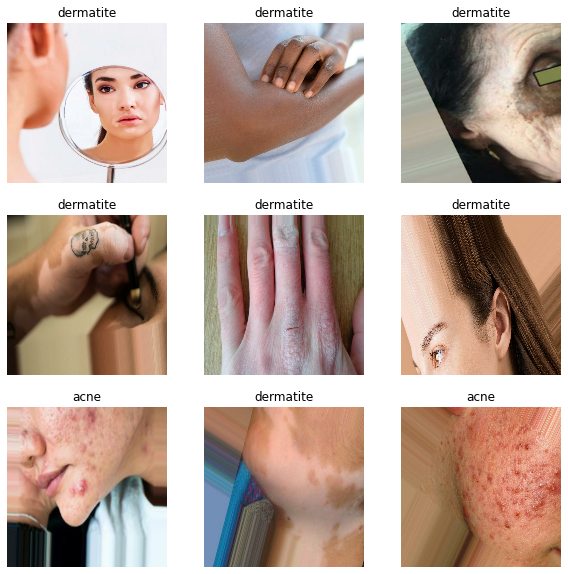

In [ ]:
# Aqui vamo usar o numpy para obter os dados de entrada que vai ser nosso conjunto de test  para a maquina avaliar e salvamos a predicao numa variavel
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aqui aplicamos a funcao sigmoid para que valores que sejam mais proximos de 1 sejam filtrados
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
#visualizacao de dados 
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
import itertools

#funcao para plotar a matrix de confusao
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
#matriz de confusao em si
confusion_matrix(predictions, label_batch)

array([[ 7,  0,  0],
       [ 4, 12,  9],
       [ 0,  0,  0]])

# Modelo construido do zero

In [ ]:
#aqui criamos um novo modelo do zero
num_classes = len(class_names)

model_10 = Sequential([
  #scaling para entrada de dados no modelo
  layers.Rescaling(1./255, input_shape=(160, 160, 3)),
  #que vai aplicar filtros, 16 fitlros para ser mais exato afim de entender a imagem 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #agrupamento de todos os filtros formando a imagem final com os filtros aplicados
  layers.MaxPooling2D(),
  #mais uma camada de convolucao, mas agora com 32 filtros
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #camada de pooling (agrupamento)
  layers.MaxPooling2D(),
  #convulao com 64 filtros
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #agrupamento
  layers.MaxPooling2D(),
  layers.Flatten(),
  #saida do modelo no tamanho de 128 pixels
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#aqui vamos repetir o processo anterior de treino e resultados

In [ ]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model_10.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
244/244 [==============================] - 57s 222ms/step - loss: 0.9966 - accuracy: 0.4929 - val_loss: 0.9324 - val_accuracy: 0.5403
Epoch 2/10
244/244 [==============================] - 54s 219ms/step - loss: 0.9022 - accuracy: 0.5625 - val_loss: 0.8077 - val_accuracy: 0.6384
Epoch 3/10
244/244 [==============================] - 56s 226ms/step - loss: 0.8106 - accuracy: 0.6252 - val_loss: 0.7407 - val_accuracy: 0.6582
Epoch 4/10
244/244 [==============================] - 55s 223ms/step - loss: 0.6899 - accuracy: 0.6872 - val_loss: 0.5927 - val_accuracy: 0.7413
Epoch 5/10
244/244 [==============================] - 56s 227ms/step - loss: 0.5568 - accuracy: 0.7658 - val_loss: 0.4427 - val_accuracy: 0.8305
Epoch 6/10
244/244 [==============================] - 55s 221ms/step - loss: 0.4169 - accuracy: 0.8338 - val_loss: 0.3424 - val_accuracy: 0.8697
Epoch 7/10
244/244 [==============================] - 55s 224ms/step - loss: 0.3059 - accuracy: 0.8815 - val_loss: 0.2855 - val_ac

In [ ]:
#aqui percebemos que nossa saida esta muito superior ao antigo modelo
loss, accuracy = model_10.evaluate(test_dataset)
print('Test accuracy :', accuracy)

48/48 [==============================] - 6s 112ms/step - loss: 0.1703 - accuracy: 0.9460
Test accuracy : 0.9459635615348816


In [ ]:
#repetimos o processo anterios de leitura de dados e separacao do mesmo
pred = model_10.predict(validation_dataset_true)
classes = np.argmax(pred, axis = 1)

image_batch, label_batch = validation_dataset_true.as_numpy_iterator().next()
predictions = model_10.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
#aqui vamo avaliar o modelo para entender se ele esta realmente bom
target_names = ['acne', 'dermatite', 'vitiligo']
#percebemos que nosso modelo esta bom pois conseguiu ler entre 80 e 90 porcento de todo o dataset com uma acuracio de 88 porcento
print(classification_report(label_batch, classes, target_names=target_names))

              precision    recall  f1-score   support

        acne       0.77      0.91      0.83        11
   dermatite       0.89      0.80      0.84        10
    vitiligo       1.00      0.91      0.95        11

    accuracy                           0.88        32
   macro avg       0.89      0.87      0.88        32
weighted avg       0.89      0.88      0.88        32



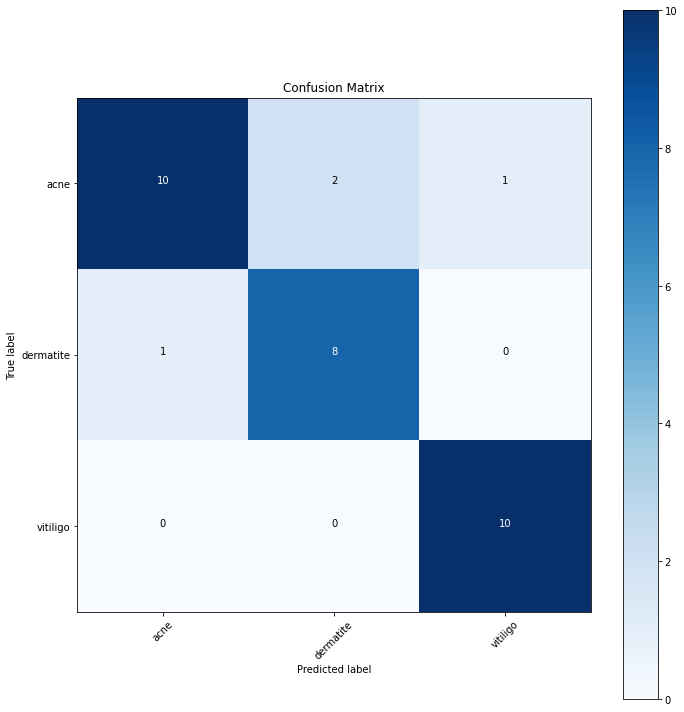

In [ ]:
target_names = ['acne', 'dermatite', 'vitiligo']
cm = confusion_matrix(classes, label_batch)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

In [ ]:
model.save('model.h5')